# Imbalanced Learning

### Artículo completo en www.aprendemachinelearning.com

## Manejo de clases desbalanceadas con la librería Python ImbLearn

No olvides instalar con:<p> pip install -U imbalanced-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
#col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
#sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

%matplotlib inline

/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Dataset Credit Card Fraud Detection

Descarga de Kaggle en https://www.kaggle.com/mlg-ulb/creditcardfraud/data

In [2]:
df = pd.read_csv("creditcard.csv") # read in data downloaded to the local directory
df.head(n=5) #just to check you imported the dataset properly4

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.shape #secondary check on the size of the dataframe

(284807, 31)

In [4]:
pd.value_counts(df['Class'], sort = True) #class comparison 0=Normal 1=Fraud

0    284315
1       492
Name: Class, dtype: int64

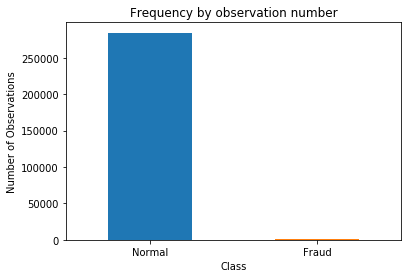

In [5]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [6]:
normal_df = df[df.Class == 0] #save normal_df observations into a separate df
fraud_df = df[df.Class == 1] #do the same for frauds

/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


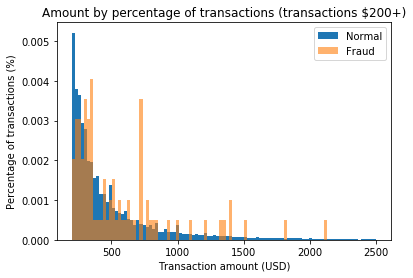

In [7]:
#plot of high value transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df.Amount, bins, alpha=1, normed=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


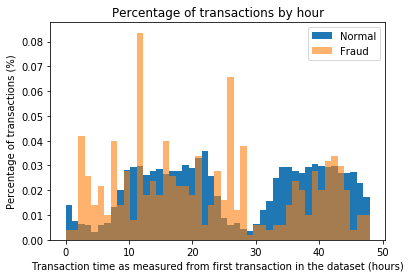

In [8]:
bins = np.linspace(0, 48, 48) #48 hours
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, normed=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
#plt.hist((df.Time/(60*60)),bins)
plt.show()

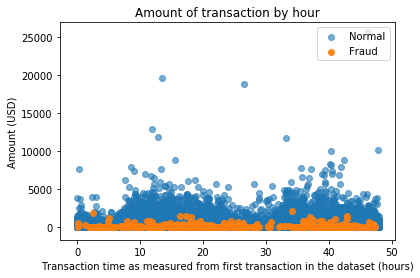

In [9]:
plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

In [10]:
y = df['Class']
X = df.drop('Class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

Text(0.5,1,'Number of observations per class')

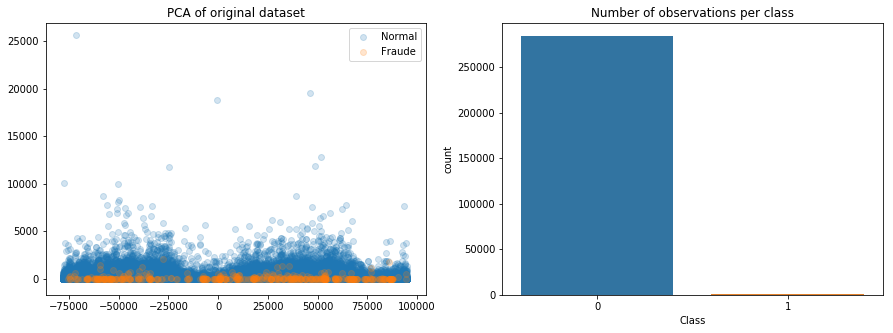

In [31]:
# Reduce dataset to 2 feature dimensions in order to visualize the data
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

fig, ax = plt.subplots(1, 2, figsize= (15,5))

ax[0].scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label="Normal", alpha=0.2)
ax[0].scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label="Fraude", alpha=0.2)
ax[0].set_title('PCA of original dataset')
ax[0].legend()

ax[1] = sns.countplot(y)
ax[1].set_title('Number of observations per class')

In [12]:
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base

# Modelo sin balancear

In [13]:
model = run_model(X_train, X_test, y_train, y_test)

/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/scipy/optimize/linesearch.py:461: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/scipy/optimize/linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/scipy/optimize/linesearch.py:461: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/scipy/optimize/linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/si

In [14]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

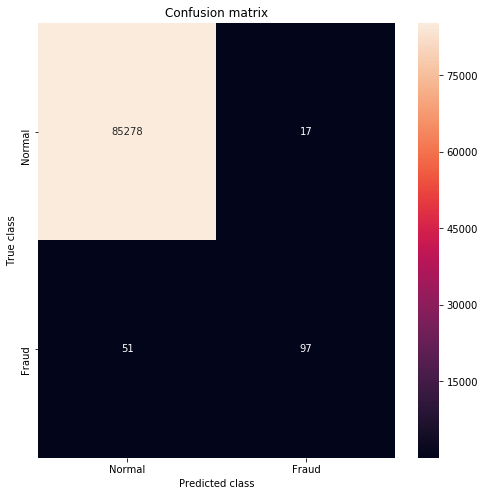

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.85      0.66      0.74       148

    accuracy                           1.00     85443
   macro avg       0.93      0.83      0.87     85443
weighted avg       1.00      1.00      1.00     85443



In [15]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# 1 Estrategia: Penalización

In [16]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)

/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


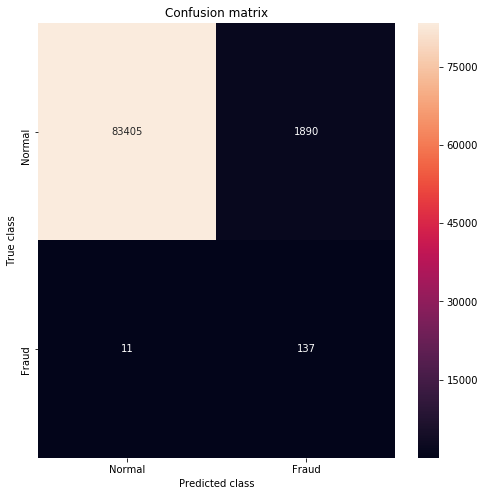

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.93      0.13       148

    accuracy                           0.98     85443
   macro avg       0.53      0.95      0.56     85443
weighted avg       1.00      0.98      0.99     85443



In [17]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# 2 NearMiss subsampling del grupo mayoritario

In [18]:
us = NearMiss(ratio=0.5, n_neighbors=3, version=2, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

Distribution of class labels before resampling Counter({0: 199020, 1: 344})
Distribution of class labels after resampling Counter({0: 688, 1: 344})


In [19]:
model = run_model(X_train_res, X_test, y_train_res, y_test)

/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


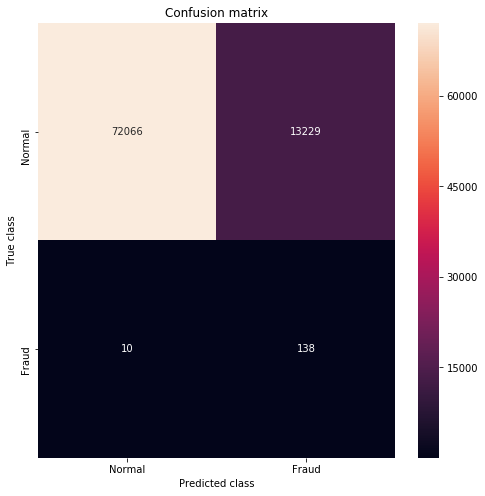

              precision    recall  f1-score   support

           0       1.00      0.84      0.92     85295
           1       0.01      0.93      0.02       148

    accuracy                           0.85     85443
   macro avg       0.51      0.89      0.47     85443
weighted avg       1.00      0.85      0.91     85443



In [20]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# 3 Random Oversampling

In [21]:
os =  RandomOverSampler(ratio=0.5)
X_train_res, y_train_res = os.fit_sample(X_train, y_train)

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

Distribution of class labels before resampling Counter({0: 199020, 1: 344})
Distribution of class labels after resampling Counter({0: 199020, 1: 99510})


In [22]:
model = run_model(X_train_res, X_test, y_train_res, y_test)

/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


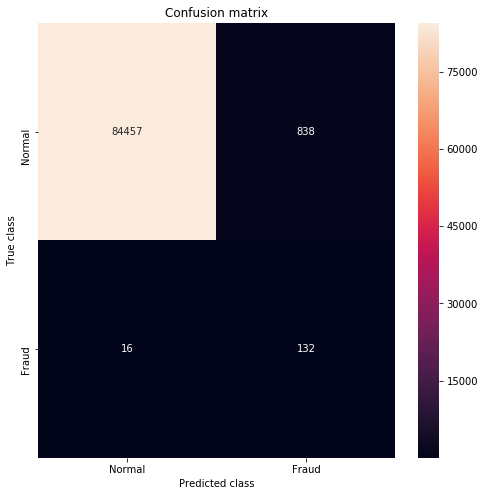

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.14      0.89      0.24       148

    accuracy                           0.99     85443
   macro avg       0.57      0.94      0.62     85443
weighted avg       1.00      0.99      0.99     85443



In [23]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# 4 Combinando Smote tomek

In [24]:
os_us = SMOTETomek(ratio=0.5)
X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

Distribution of class labels before resampling Counter({0: 199020, 1: 344})
Distribution of class labels after resampling Counter({0: 198194, 1: 98684})


In [25]:
model = run_model(X_train_res, X_test, y_train_res, y_test)

/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/scipy/optimize/linesearch.py:461: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/scipy/optimize/linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


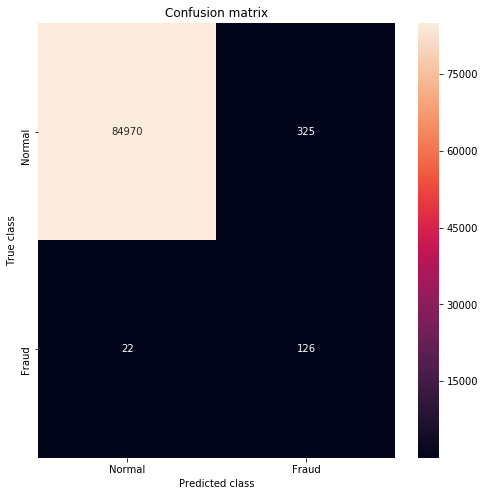

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.28      0.85      0.42       148

    accuracy                           1.00     85443
   macro avg       0.64      0.92      0.71     85443
weighted avg       1.00      1.00      1.00     85443



In [26]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# 5 Ensemble balanceado

In [27]:
#Create an object of the classifier.
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

#Train the classifier.
bbc.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                criterion='gini',
                                                                max_depth=None,
                                                                max_features=None,
                                                                max_leaf_nodes=None,
                                                                min_impurity_decrease=0.0,
                                                                min_impurity_split=None,
                                                                min_samples_leaf=1,
                                                                min_samples_split=2,
                                                                min_weight_fraction_leaf=0.0,
                                                                presort=False,
                                                                r

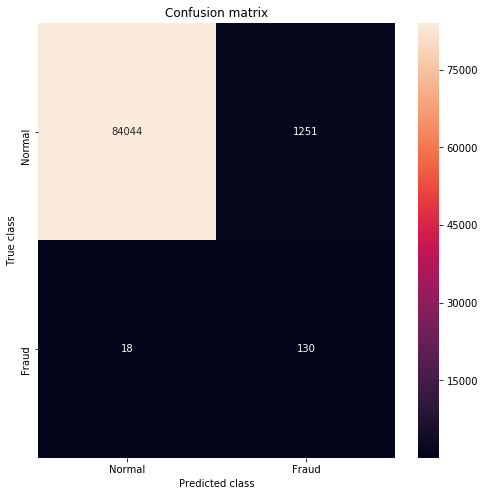

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.09      0.88      0.17       148

    accuracy                           0.99     85443
   macro avg       0.55      0.93      0.58     85443
weighted avg       1.00      0.99      0.99     85443



In [28]:
pred_y = bbc.predict(X_test)
mostrar_resultados(y_test, pred_y)

# Resultados

In [30]:
df = pd.DataFrame({'algorithm' : ['Regresion Logística', 'Penalizacion', 'NearMiss Subsampling', 
                                  'Random Oversampling', 'Smote Tomek', 'Ensemble'],
                   'precision' : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                   'recall' : [0.66, 0.93, 0.93, 0.89, 0.85, 0.88]})

df['overall'] = df.apply(lambda row: (row.precision + row.recall)/2, axis=1)

df = df.sort_values(['overall'], ascending=False)
df

,algorithm,precision,recall,overall
1,Penalizacion,1.0,0.93,0.965
2,NearMiss Subsampling,1.0,0.93,0.965
3,Random Oversampling,1.0,0.89,0.945
5,Ensemble,1.0,0.88,0.940
4,Smote Tomek,1.0,0.85,0.925
0,Regresion Logística,1.0,0.66,0.830
